In [ ]:
import cv2
import json
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [70]:
tools = ['accendino', 'cacciavite', 'chiave', 'forbici', 'martello', 'metro', 'pappagallo', 'penna', 'spillatrice']
tp_tot, tn_tot, fp_tot, fn_tot = [], [], [], []


for tool in tqdm(tools):

    with open(f"C:/Users\mcm23\OneDrive\Desktop\GitHub\Object_Detection\images\{tool}\{tool}_gt.json", 'r') as f:
        ground_truth_file = json.load(f)

    for pos, el in enumerate(ground_truth_file):

        if pos < 5:
            truth_mask = np.zeros((520, 520))
            image = cv2.imread(f"C:/Users\mcm23\OneDrive\Desktop\GitHub\Object_Detection\images\{tool}\{tool}_{pos+1}.png")

            for i in range(len(ground_truth_file[el]['regions'])):

                x_pos = ground_truth_file[el]['regions'][i]['shape_attributes']['all_points_x']
                y_pos = ground_truth_file[el]['regions'][i]['shape_attributes']['all_points_y']
                vertices = np.array([[x_pos[u], y_pos[u]] for u in range(len(x_pos))])
                if i == 0:
                        cv2.fillPoly(truth_mask, [vertices], 255)
                else:
                        cv2.fillPoly(truth_mask, [vertices], 0)

            # Ground truth.
            x_pos = ground_truth_file[el]['regions'][0]['shape_attributes']['all_points_x']
            y_pos = ground_truth_file[el]['regions'][0]['shape_attributes']['all_points_y']
            vertices = np.array([[x_pos[i], y_pos[i]] for i in range(len(x_pos))])

            # Preprocessing
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray = cv2.GaussianBlur(gray, (3, 3), cv2.BORDER_DEFAULT)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
            gray = cv2.erode(gray, kernel, iterations=3)


            ## Different segmentations.

            # 1) Sogliaura di OTSU
            # _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

            # 2) K-means
            small = cv2.pyrDown(gray)
            Z = small.reshape((-1, 1))
            Z = np.float32(Z)
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
            K = 2
            ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
            center = np.uint8(center)
            res = center[label.flatten()]
            res2 = res.reshape((small.shape))
            res2 = cv2.pyrUp(res2)
            # _, mask = cv2.threshold(res2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)



            # # 1)
            # # CANNY Edge Detection
            # edges = cv2.Canny(gray, threshold1=30, threshold2=100)
            # _, binary_image = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

            # # 2)
            # # Binarizzazione Adattiva
            # thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)



            # cv2.imshow("Masked Image", mask)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()

            

            # Ground truth mask
            truth_mask = truth_mask.astype(bool).flatten()
            opening = mask.astype(bool)

            # Confronto tra segmentazione e ground truth.
            ground_truth = truth_mask.flatten()
            predictions = [not elem for elem in opening.flatten()]

            tn, fp, fn, tp = confusion_matrix(ground_truth, predictions, labels=[True, False]).ravel()
            tp_tot.append(tp)
            tn_tot.append(tn)
            fp_tot.append(fp)
            fn_tot.append(fn)

100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


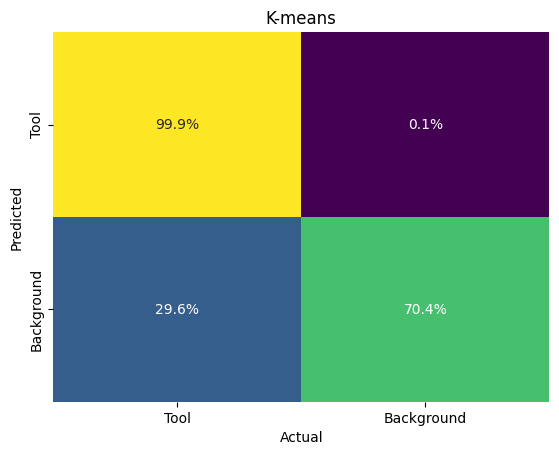

In [73]:
sum_tp, sum_tn, sum_fp, sum_fn = sum(tp_tot), sum(tn_tot), sum(fp_tot), sum(fn_tot) 

cf_matrix = np.array([[sum_tp/(sum_tp+sum_fp), sum_fp/(sum_tp+sum_fp)],
                       [sum_fn/(sum_tn+sum_fn), sum_tn/(sum_tn+sum_fn)]])

labels = ['Tool', 'Background']
sns.heatmap(cf_matrix, annot=True, cmap='viridis',  xticklabels=labels, yticklabels=labels, cbar=False, fmt=".1%")
plt.title("K-means")
plt.xlabel('Actual')
plt.ylabel('Predicted');